Epoch 1/50
40/40 [==============================] - 2s 28ms/step - loss: 0.0323 - val_loss: 0.0151
Epoch 2/50
40/40 [==============================] - 1s 21ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 3/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 4/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 5/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 6/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 7/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 8/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 9/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 11/

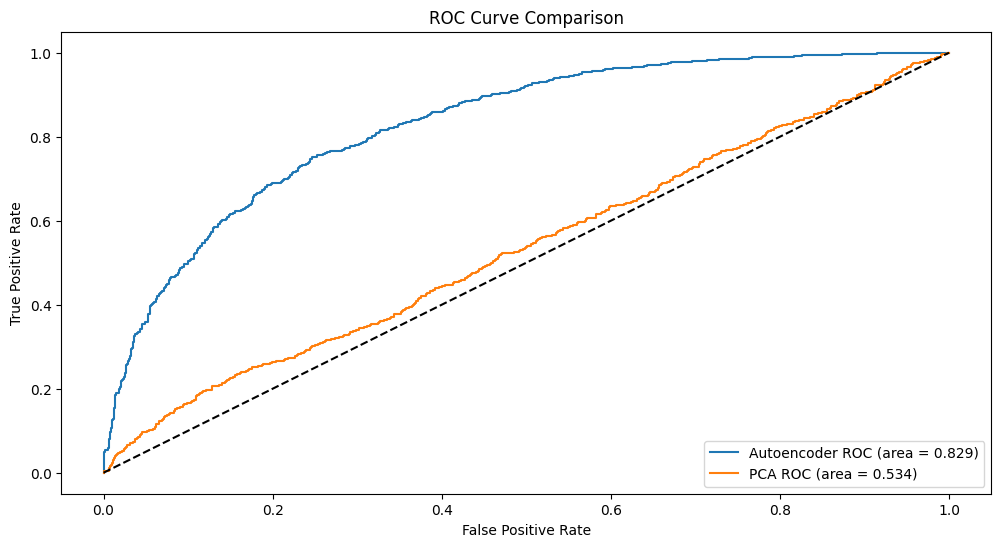

Autoencoder AUC-ROC: 0.8292050000000001
PCA AUC-ROC: 0.534351


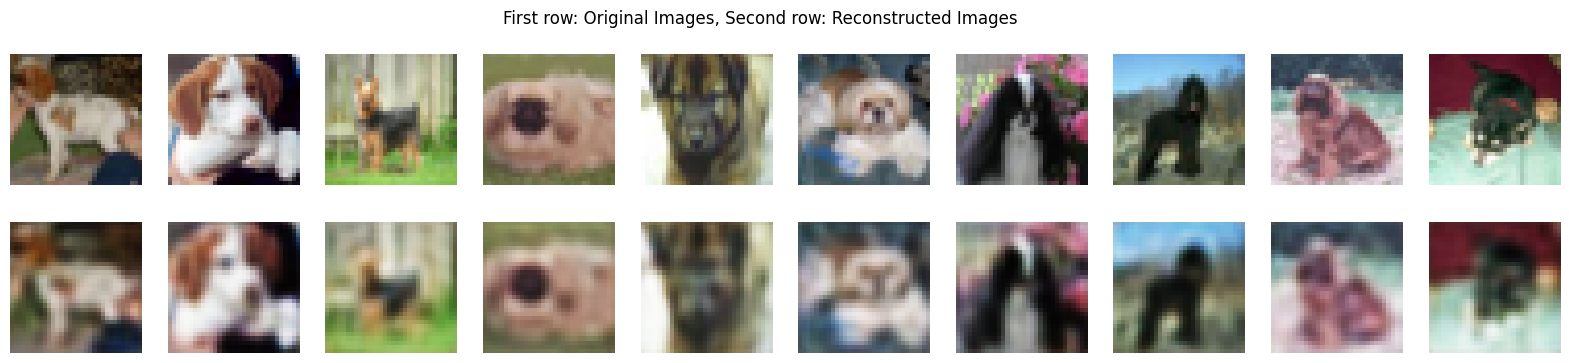

In [ ]:
# Autoencoder structure for CIFAR-10 dataset

!pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#Autoencoder AUC-ROC: 0.823791, PCA AUC-ROC: 0.533899, Bayesian Optimization
#Autoencoder AUC-ROC: 0.824631, PCA AUC-ROC: 0.53372, Hypeband

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#Autoencoder AUC-ROC: 0.905897, PCA AUC-ROC: 0.441662, Normal Class- 5, Anomalous class - 1

#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#Autoencoder AUC-ROC: 0.014814819936390026, PCA AUC-ROC: 0.596880741194366, Normal Class- 5, Anomalous class - 1

'''
if True:
    # Load the SVHN Cropped dataset using TensorFlow Datasets
    (train_data, test_data), info = tfds.load('svhn_cropped', split=['train', 'test'], with_info=True, as_supervised=True)

    # Convert to numpy arrays
    x_train, y_train = [], []
    x_test, y_test = [], []

    for image, label in tfds.as_numpy(train_data):
        x_train.append(image)
        y_train.append(label)

    for image, label in tfds.as_numpy(test_data):
        x_test.append(image)
        y_test.append(label)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
'''
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
#Autoencoder AUC-ROC: 0.841, PCA AUC-ROC: 0.46990000000000004, Normal Class- 5, Anomalous class - 1

'''
if True: #Autoencoder AUC-ROC: 0.552798, PCA AUC-ROC: 0.424458
    # Load the KMNIST dataset using TensorFlow Datasets
    (train_data, test_data), info = tfds.load('kmnist', split=['train', 'test'], with_info=True, as_supervised=True)

    # Convert to numpy arrays
    x_train, y_train = [], []
    x_test, y_test = [], []

    for image, label in tfds.as_numpy(train_data):
        x_train.append(image[:,:,0])
        y_train.append(label)

    for image, label in tfds.as_numpy(test_data):
        x_test.append(image[:,:,0])
        y_test.append(label)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape and preprocess the data
    x_train = np.expand_dims(x_train, axis=-1)  # Add a channel dimension
    x_test = np.expand_dims(x_test, axis=-1)
    x_train = np.repeat(x_train, 3, axis=-1)  # Repeat channels to get 3-channel images
    x_test = np.repeat(x_test, 3, axis=-1)

    x_train = tf.image.resize(x_train, [32, 32]) / 255.0
    x_test = tf.image.resize(x_test, [32, 32]) / 255.0

    # Convert to numpy arrays if they are not already
    x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
    x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test
'''

if len(x_train.shape) == 3:  
    x_train = np.expand_dims(x_train, axis=-1) 
    x_test = np.expand_dims(x_test, axis=-1)
    x_train = np.repeat(x_train, 3, axis=-1) 
    x_test = np.repeat(x_test, 3, axis=-1)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

normal_class = 5
anomalous_class = 1

x_train_normal = x_train[np.squeeze(y_train) == normal_class]
x_test_normal = x_test[np.squeeze(y_test) == normal_class]
x_test_anomalous = x_test[np.squeeze(y_test) == anomalous_class]


resnet_encoder = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in resnet_encoder.layers:
    layer.trainable = True

def build_autoencoder_with_resnet():
    input_img = Input(shape=(32, 32, 3))
    encoded = resnet_encoder(input_img)

    encoded_flatten = Flatten()(encoded)

    x = Reshape((4, 4, 128))(encoded_flatten)  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

def build_basic_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

def build_deep_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

def build_varied_filter_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

optimizer1 = Adam(learning_rate=0.003269679082196687)
optimizer2 = Adam(learning_rate=0.0021604528952830415)
optimizer3 = Adam(learning_rate=0.0033253069486550236)

autoencoder1 = build_basic_autoencoder()
autoencoder2 = build_deep_autoencoder()
autoencoder3 = build_varied_filter_autoencoder()

autoencoder1.compile(optimizer=optimizer1, loss='mean_squared_error')
autoencoder2.compile(optimizer=optimizer2, loss='mean_squared_error')
autoencoder3.compile(optimizer=optimizer3, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy')

augmentation_generator = ImageDataGenerator(
    #rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i in range(x_train_normal.shape[0]):
    img = x_train_normal[i]
    img = img.reshape((1,) + img.shape)
    for x_batch in augmentation_generator.flow(img, batch_size=1):
        augmented_images.append(x_batch[0])
        break  

augmented_images = np.array(augmented_images)

extended_train_images = np.concatenate((x_train_normal, augmented_images))

# Training Autoencoder 1
history1 = autoencoder1.fit(
    extended_train_images, extended_train_images,
    epochs=50, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

# Training Autoencoder 2
history2 = autoencoder2.fit(
    extended_train_images, extended_train_images,
    epochs=50, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

# Training Autoencoder 3
history3 = autoencoder3.fit(
    extended_train_images, extended_train_images,
    epochs=50, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

reconstruction_normal_1 = autoencoder1.predict(x_test_normal)
reconstruction_normal_2 = autoencoder2.predict(x_test_normal)
reconstruction_normal_3 = autoencoder3.predict(x_test_normal)

reconstruction_anomalous_1 = autoencoder1.predict(x_test_anomalous)
reconstruction_anomalous_2 = autoencoder2.predict(x_test_anomalous)
reconstruction_anomalous_3 = autoencoder3.predict(x_test_anomalous)

#reconstruction_normal = (reconstruction_normal_1 + reconstruction_normal_2 + reconstruction_normal_3) / 3
#reconstruction_anomalous = (reconstruction_anomalous_1 + reconstruction_anomalous_2 + reconstruction_anomalous_3) / 3
reconstruction_normal = reconstruction_normal_1 
reconstruction_anomalous = reconstruction_anomalous_1

mae_normal = np.mean(np.abs(reconstruction_normal - x_test_normal), axis=(1,2,3))
mae_anomalous = np.mean(np.abs(reconstruction_anomalous - x_test_anomalous), axis=(1,2,3))
errors = np.concatenate([mae_normal, mae_anomalous])

labels = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_anomalous))])
auc_roc_autoencoder = roc_auc_score(labels, errors)

encoded_features = np.concatenate([reconstruction_normal, reconstruction_anomalous], axis=0)
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(encoded_features_flat)
auc_roc_pca = roc_auc_score(labels, np.linalg.norm(pca_features, axis=1))

fpr_autoencoder, tpr_autoencoder, _ = roc_curve(labels, errors)
fpr_pca, tpr_pca, _ = roc_curve(labels, np.linalg.norm(pca_features, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder ROC (area = {:.3f})'.format(auc_roc_autoencoder))
plt.plot(fpr_pca, tpr_pca, label='PCA ROC (area = {:.3f})'.format(auc_roc_pca))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('PCA AUC-ROC:', auc_roc_pca)

n = 10  
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    original_image = x_test_normal[i].reshape(32, 32, 3)
    plt.imshow(original_image)
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_image = reconstruction_normal[i].reshape(32, 32, 3)
    plt.imshow(reconstructed_image)
    ax.axis('off')

plt.suptitle("First row: Original Images, Second row: Reconstructed Images")
plt.show()

In [ ]:
# Comparison of CIFAR-10 With the best method from the ADBENCH

from sklearn.neighbors import LocalOutlierFactor

x_train_normal_flat = x_train_normal.reshape((x_train_normal.shape[0], -1))
x_test_normal_flat = x_test_normal.reshape((x_test_normal.shape[0], -1))
x_test_anomalous_flat = x_test_anomalous.reshape((x_test_anomalous.shape[0], -1))

lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(x_train_normal_flat)

lof_scores_normal = -lof.decision_function(x_test_normal_flat) 
lof_scores_anomalous = -lof.decision_function(x_test_anomalous_flat)

lof_scores = np.concatenate([lof_scores_normal, lof_scores_anomalous])
lof_labels = np.concatenate([np.zeros(len(lof_scores_normal)), np.ones(len(lof_scores_anomalous))])

auc_roc_lof = roc_auc_score(lof_labels, lof_scores)

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('LOF AUC-ROC:', auc_roc_lof)

Autoencoder AUC-ROC: 0.8292050000000001
LOF AUC-ROC: 0.7398815


In [ ]:
#Best hyperparameter for CIFAR-10 using the Bayesian Optimization

!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from kerastuner import BayesianOptimization

# Load CIFAR10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Select 'normal' and 'anomalous' classes
normal_class = 5
anomalous_class = 1

x_train_normal = x_train[y_train.flatten() == normal_class]
x_test_normal = x_test[y_test.flatten() == normal_class]
x_test_anomalous = x_test[y_test.flatten() == anomalous_class]

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_basic', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_varied_filter_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_varied_filter', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

optimal_learning_rates = {}

for build_fn, learning_rate_key in zip(
    [build_basic_autoencoder, build_deep_autoencoder, build_varied_filter_autoencoder],
    ['learning_rate_basic', 'learning_rate_deep', 'learning_rate_varied_filter']):

    tuner = BayesianOptimization(
        build_fn,
        objective='val_loss',
        max_trials=10,
        directory='autoencoder_tuning',
        project_name='cifar10_autoencoder',
        overwrite=True
    )
    tuner.search(x_train_normal, x_train_normal, epochs=10, validation_data=(x_test_normal, x_test_normal))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_learning_rates[build_fn.__name__] = best_hps.get(learning_rate_key)

for architecture, lr in optimal_learning_rates.items():
    print(f"Best learning rate for {architecture}: {lr}")


Trial 10 Complete [00h 00m 13s]
val_loss: 0.004630605224519968

Best val_loss So Far: 0.002853734651580453
Total elapsed time: 00h 02m 39s
Best learning rate for build_basic_autoencoder: 0.0031807865668076873
Best learning rate for build_deep_autoencoder: 0.0015801070675676568
Best learning rate for build_varied_filter_autoencoder: 0.0023158487675117227


In [ ]:
#Best hyperparameter for CIFAR-10 using the Hyperband
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from kerastuner import BayesianOptimization
from kerastuner.tuners import Hyperband

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

normal_class = 5
anomalous_class = 1

x_train_normal = x_train[y_train.flatten() == normal_class]
x_test_normal = x_test[y_test.flatten() == normal_class]
x_test_anomalous = x_test[y_test.flatten() == anomalous_class]

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_basic', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_varied_filter_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_varied_filter', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

optimal_learning_rates = {}

for build_fn, learning_rate_key in zip(
    [build_basic_autoencoder, build_deep_autoencoder, build_varied_filter_autoencoder],
    ['learning_rate_basic', 'learning_rate_deep', 'learning_rate_varied_filter']):

    tuner = Hyperband(
        build_fn,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='hyperband_tuning',
        project_name='cifar10_autoencoder',
        overwrite=True
    )
    tuner.search(x_train_normal, x_train_normal, epochs=10, validation_split=0.2)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_learning_rates[build_fn.__name__] = best_hps.get(learning_rate_key)

for architecture, lr in optimal_learning_rates.items():
    print(f"Best learning rate for {architecture}: {lr}")

Trial 30 Complete [00h 00m 12s]
val_loss: 0.007868306711316109

Best val_loss So Far: 0.0031230119056999683
Total elapsed time: 00h 03m 38s
Best learning rate for build_basic_autoencoder: 0.003269679082196687
Best learning rate for build_deep_autoencoder: 0.0021604528952830415
Best learning rate for build_varied_filter_autoencoder: 0.0033253069486550236


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/50
47/47 [==============================] - 2s 32ms/step - loss: 0.0318 - val_loss: 0.0094
Epoch 2/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 3/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 4/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/50
47/47 [===========================

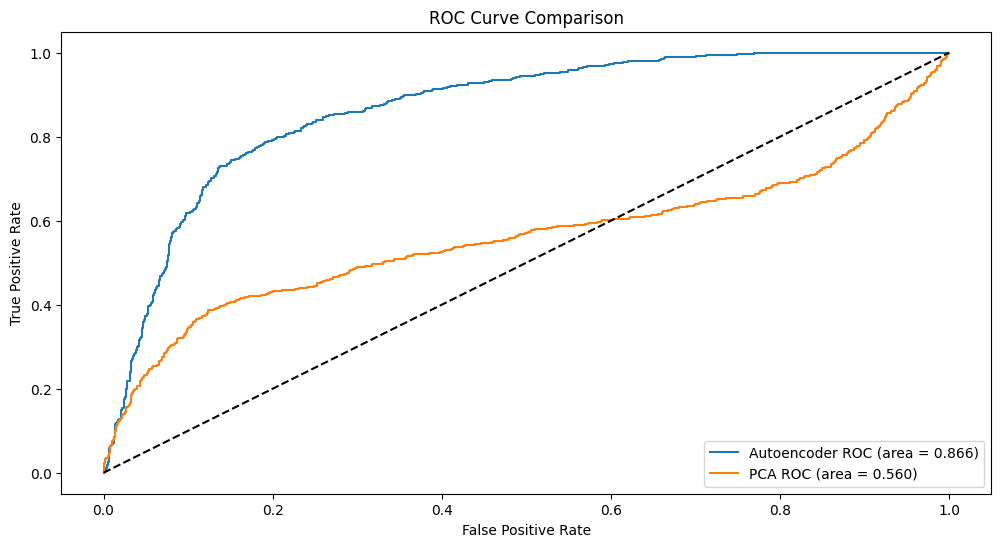

Autoencoder AUC-ROC: 0.8660410000000001
PCA AUC-ROC: 0.560288


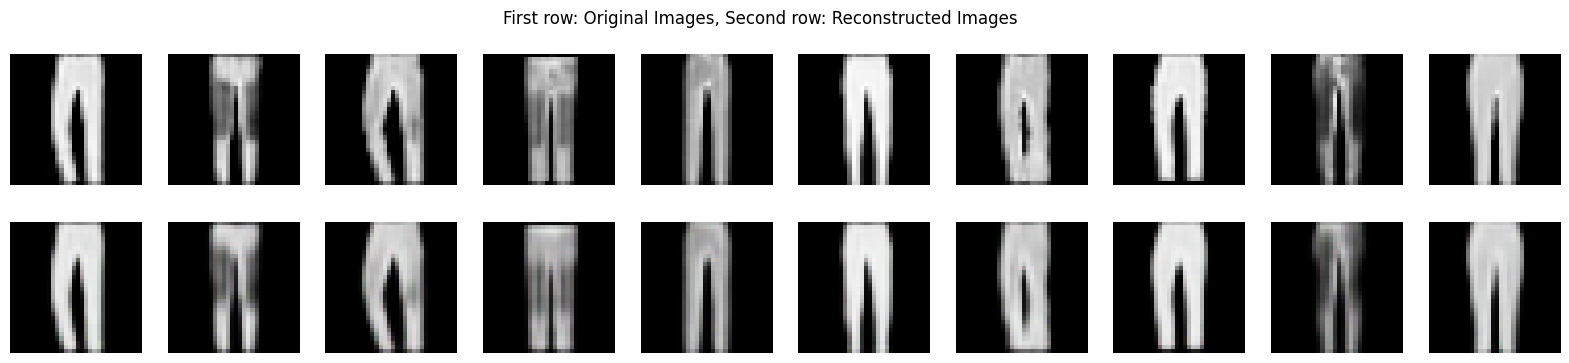

In [ ]:
# Autoencoder structure for FASHION_MNIST dataset

!pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#Autoencoder AUC-ROC: 0.87588, PCA AUC-ROC: 0.563775, Bayesian Optimization
#Autoencoder AUC-ROC: 0.87467, PCA AUC-ROC: 0.5569120000000001, Hyperband

if len(x_train.shape) == 3:  
    x_train = np.expand_dims(x_train, axis=-1) 
    x_test = np.expand_dims(x_test, axis=-1)
    x_train = np.repeat(x_train, 3, axis=-1) 
    x_test = np.repeat(x_test, 3, axis=-1)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

normal_class = 1
anomalous_class = 3

x_train_normal = x_train[np.squeeze(y_train) == normal_class]
x_test_normal = x_test[np.squeeze(y_test) == normal_class]
x_test_anomalous = x_test[np.squeeze(y_test) == anomalous_class]

resnet_encoder = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in resnet_encoder.layers:
    layer.trainable = True

def build_autoencoder_with_resnet():
    input_img = Input(shape=(32, 32, 3))
    encoded = resnet_encoder(input_img)

    encoded_flatten = Flatten()(encoded)

    x = Reshape((4, 4, 128))(encoded_flatten)  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

def build_basic_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

optimizer1 = Adam(learning_rate=0.0029174337190087316)

autoencoder1 = build_basic_autoencoder()

autoencoder1.compile(optimizer=optimizer1, loss='mean_squared_error')
#autoencoder1.compile(optimizer=optimizer1, loss='binary_crossentropy') # Performing poorly than 'mean_squared_error'

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

augmentation_generator = ImageDataGenerator(
    #rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i in range(x_train_normal.shape[0]):
    img = x_train_normal[i]
    img = img.reshape((1,) + img.shape)
    for x_batch in augmentation_generator.flow(img, batch_size=1):
        augmented_images.append(x_batch[0])
        break  

augmented_images = np.array(augmented_images)

extended_train_images = np.concatenate((x_train_normal, augmented_images))

history1 = autoencoder1.fit(
    extended_train_images, extended_train_images,
    epochs=50, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

reconstruction_normal_1 = autoencoder1.predict(x_test_normal)

reconstruction_anomalous_1 = autoencoder1.predict(x_test_anomalous)

reconstruction_normal = reconstruction_normal_1
reconstruction_anomalous = reconstruction_anomalous_1

mae_normal = np.mean(np.abs(reconstruction_normal - x_test_normal), axis=(1,2,3))
mae_anomalous = np.mean(np.abs(reconstruction_anomalous - x_test_anomalous), axis=(1,2,3))
errors = np.concatenate([mae_normal, mae_anomalous])

labels = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_anomalous))])
auc_roc_autoencoder = roc_auc_score(labels, errors)

encoded_features = np.concatenate([reconstruction_normal, reconstruction_anomalous], axis=0)
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(encoded_features_flat)
auc_roc_pca = roc_auc_score(labels, np.linalg.norm(pca_features, axis=1))

fpr_autoencoder, tpr_autoencoder, _ = roc_curve(labels, errors)
fpr_pca, tpr_pca, _ = roc_curve(labels, np.linalg.norm(pca_features, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder ROC (area = {:.3f})'.format(auc_roc_autoencoder))
plt.plot(fpr_pca, tpr_pca, label='PCA ROC (area = {:.3f})'.format(auc_roc_pca))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('PCA AUC-ROC:', auc_roc_pca)

n = 10  # Number of samples to display
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    original_image = x_test_normal[i].reshape(32, 32, 3)
    plt.imshow(original_image)
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_image = reconstruction_normal_1[i].reshape(32, 32, 3)
    plt.imshow(reconstructed_image)
    ax.axis('off')

plt.suptitle("First row: Original Images, Second row: Reconstructed Images")
plt.show()

In [ ]:
# Comparison of FASHION-MNIST With the best method from the ADBENCH
!pip install numpy tensorflow scikit-learn pyod
import sys
!{sys.executable} -m pip install --upgrade attrs pytest
!{sys.executable} -m pip install --upgrade pyod

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyod.models.cblof import CBLOF
from sklearn.metrics import roc_auc_score

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)
x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0
x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

# Select one class as 'normal' and another as 'anomalous'
normal_class = 1
anomalous_class = 3
x_train_normal = x_train[np.squeeze(y_train) == normal_class]
x_test_normal = x_test[np.squeeze(y_test) == normal_class]
x_test_anomalous = x_test[np.squeeze(y_test) == anomalous_class]

x_train_normal_flat = x_train_normal.reshape((x_train_normal.shape[0], -1))
x_test_normal_flat = x_test_normal.reshape((x_test_normal.shape[0], -1))
x_test_anomalous_flat = x_test_anomalous.reshape((x_test_anomalous.shape[0], -1))

cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=42)
cblof.fit(x_train_normal_flat)

cblof_scores_normal = -cblof.decision_function(x_test_normal_flat)
cblof_scores_anomalous = -cblof.decision_function(x_test_anomalous_flat)

cblof_scores = np.concatenate([cblof_scores_normal, cblof_scores_anomalous])
cblof_labels = np.concatenate([np.zeros(len(cblof_scores_normal)), np.ones(len(cblof_scores_anomalous))])

auc_roc_cblof = roc_auc_score(cblof_labels, cblof_scores)

print('CBLOF AUC-ROC:', auc_roc_cblof)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: pytest
    Found existing installation: pytest 7.2.1
    Uninstalling pytest-7.2.1:
      Successfully uninstalled pytest-7.2.1
CBLOF AUC-ROC: 0.05632000000000001


In [ ]:
#Best hyperparameter for FASHION-MNIST using the Bayesian Optimization

!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import BayesianOptimization

# Load FASHION-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Select 'normal' and 'anomalous' classes
normal_class = 1
anomalous_class = 3

x_train_normal = x_train[y_train == normal_class]
x_test_normal = x_test[y_test == normal_class]
x_test_anomalous = x_test[y_test == anomalous_class]

x_train_normal = x_train_normal.astype('float32') / 255.0
x_test_normal = x_test_normal.astype('float32') / 255.0
x_test_anomalous = x_test_anomalous.astype('float32') / 255.0

x_train_normal = np.expand_dims(x_train_normal, -1)
x_train_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_train_normal])

x_test_normal = np.expand_dims(x_test_normal, -1)
x_test_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_test_normal])

x_test_anomalous = np.expand_dims(x_test_anomalous, -1)
x_test_anomalous = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_test_anomalous])

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 1))
    # Encoder
    x = Conv2D(hp.Int('encoder_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('decoder_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(hp.Int('decoder_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hp.Int('encoder_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Adjust output channels
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

tuner = BayesianOptimization(
    build_basic_autoencoder,
    objective='val_loss',
    max_trials=10,
    directory='autoencoder_tuning',
    project_name='bayesian_fashionmnist_autoencoder',
    overwrite=True
)

tuner.search(x_train_normal, x_train_normal, epochs=10, validation_data=(x_test_normal, x_test_normal))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 00m 22s]
val_loss: 0.0008722731145098805

Best val_loss So Far: 0.0006169741391204298
Total elapsed time: 00h 03m 25s
Best learning rate: 0.004762210760971595


In [ ]:
#Best hyperparameter for FASHION-MNIST using the Hyperband

!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import Hyperband

# Load FASHION-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
normal_class, anomalous_class = 1, 3
x_train_normal = x_train[y_train == normal_class]
x_test_normal = x_test[y_test == normal_class]
x_test_anomalous = x_test[y_test == anomalous_class]

x_train_normal = np.expand_dims(x_train_normal / 255.0, -1)
x_train_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_train_normal])

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 1))
    # Encoder
    x = Conv2D(hp.Int('encoder_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('decoder_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(hp.Int('decoder_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hp.Int('encoder_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

tuner = Hyperband(
    build_basic_autoencoder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband_tuning',
    project_name='hyperband_fashionmnist_autoencoder',
    overwrite=True
)

tuner.search(x_train_normal, x_train_normal, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 00m 12s]
val_loss: 0.0007903724908828735

Best val_loss So Far: 0.0006096544093452394
Total elapsed time: 00h 03m 42s
Best learning rate: 0.0029174337190087316


  Using cached protobuf-4.25.2-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached protobuf-3.20.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/50
53/53 [==============================] - 2s 33ms/step - loss: 0.1754 - val_loss: 0.0666
Epoch 2/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0697 - val_loss: 0.0616
Epoch 3/50
53/53 [==========

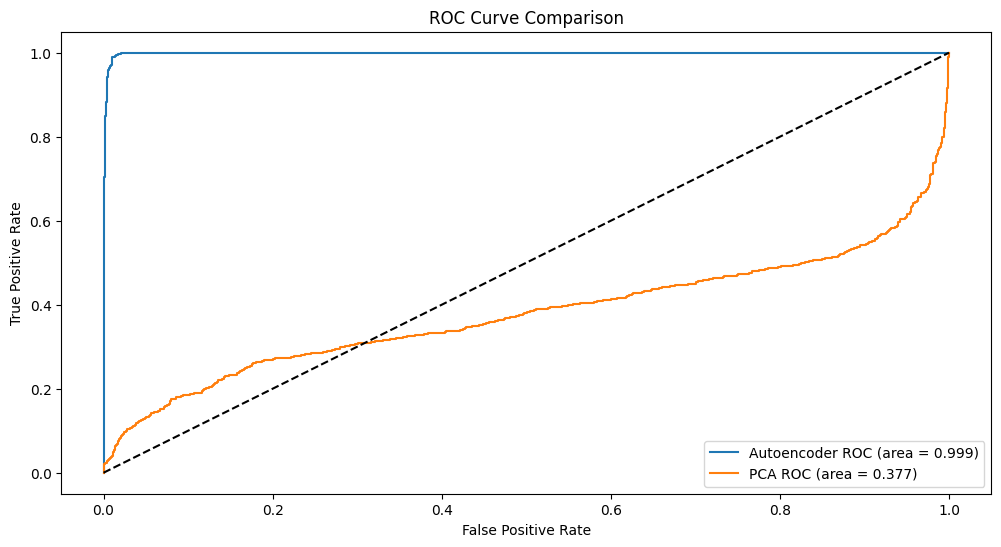

Autoencoder AUC-ROC: 0.9988075195184717
PCA AUC-ROC: 0.3772556374580189


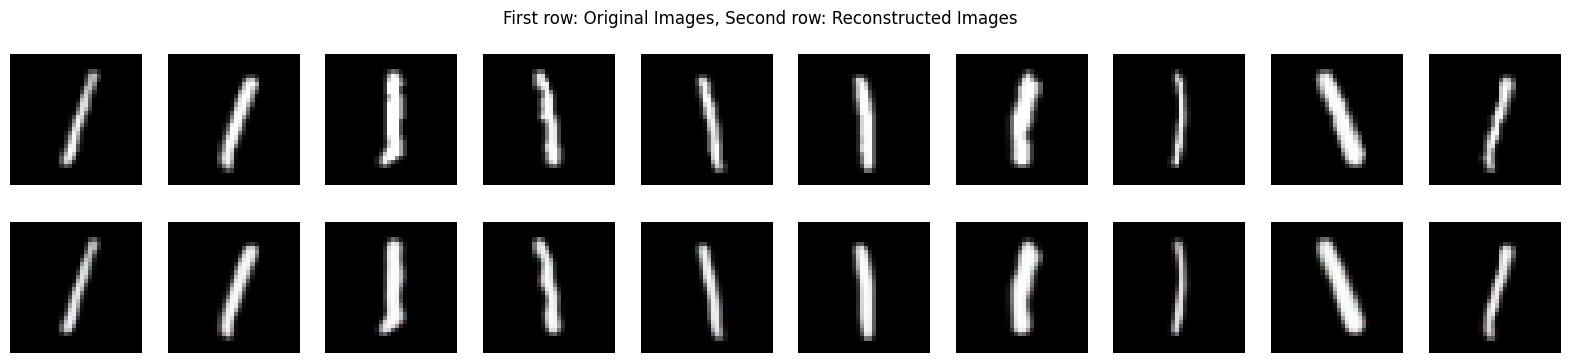

In [ ]:
# Autoencoder structure for MNIST dataset

!pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#Autoencoder AUC-ROC: 0.9989898373097221, PCA AUC-ROC: 0.3639132900074148, Bayesian

if len(x_train.shape) == 3:  
    x_train = np.expand_dims(x_train, axis=-1) 
    x_test = np.expand_dims(x_test, axis=-1)
    x_train = np.repeat(x_train, 3, axis=-1)  
    x_test = np.repeat(x_test, 3, axis=-1)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

# Select one class as 'normal' and another as 'anomalous'
normal_class = 1
anomalous_class = 3

x_train_normal = x_train[np.squeeze(y_train) == normal_class]
x_test_normal = x_test[np.squeeze(y_test) == normal_class]
x_test_anomalous = x_test[np.squeeze(y_test) == anomalous_class]

def build_varied_filter_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    # Encoder
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

optimizer3 = Adam(learning_rate=0.0011657917326969754)

autoencoder3 = build_varied_filter_autoencoder()
#autoencoder3.compile(optimizer=optimizer3, loss='mean_squared_error')
autoencoder3.compile(optimizer=optimizer3, loss='binary_crossentropy') # Performing better than 'mean_squared_error' loss

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

augmentation_generator = ImageDataGenerator(
    #rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i in range(x_train_normal.shape[0]):
    img = x_train_normal[i]
    img = img.reshape((1,) + img.shape)
    for x_batch in augmentation_generator.flow(img, batch_size=1):
        augmented_images.append(x_batch[0])
        break  # We only need one augmented image per original image

augmented_images = np.array(augmented_images)

extended_train_images = np.concatenate((x_train_normal, augmented_images))

history3 = autoencoder3.fit(
    extended_train_images, extended_train_images,
    epochs=50, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

reconstruction_normal_3 = autoencoder3.predict(x_test_normal)
reconstruction_anomalous_3 = autoencoder3.predict(x_test_anomalous)

reconstruction_normal = reconstruction_normal_3
reconstruction_anomalous = reconstruction_anomalous_3

mae_normal = np.mean(np.abs(reconstruction_normal - x_test_normal), axis=(1,2,3))
mae_anomalous = np.mean(np.abs(reconstruction_anomalous - x_test_anomalous), axis=(1,2,3))
errors = np.concatenate([mae_normal, mae_anomalous])

labels = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_anomalous))])
auc_roc_autoencoder = roc_auc_score(labels, errors)

encoded_features = np.concatenate([reconstruction_normal, reconstruction_anomalous], axis=0)
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(encoded_features_flat)
auc_roc_pca = roc_auc_score(labels, np.linalg.norm(pca_features, axis=1))

fpr_autoencoder, tpr_autoencoder, _ = roc_curve(labels, errors)
fpr_pca, tpr_pca, _ = roc_curve(labels, np.linalg.norm(pca_features, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder ROC (area = {:.3f})'.format(auc_roc_autoencoder))
plt.plot(fpr_pca, tpr_pca, label='PCA ROC (area = {:.3f})'.format(auc_roc_pca))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('PCA AUC-ROC:', auc_roc_pca)

n = 10  
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    original_image = x_test_normal[i].reshape(32, 32, 3)
    plt.imshow(original_image)
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_image = reconstruction_normal_3[i].reshape(32, 32, 3)
    plt.imshow(reconstructed_image)
    ax.axis('off')

plt.suptitle("First row: Original Images, Second row: Reconstructed Images")
plt.show()

In [ ]:
# Finding the AUC-ROC score of the best method provided in ADBENCH for MNIST Dataset
!pip install numpy tensorflow scikit-learn pyod

import numpy as np
import tensorflow as tf
from pyod.models.knn import KNN
from sklearn.metrics import roc_auc_score

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)
x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0
x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

# Select normal and anomalous classes
normal_class = 1
anomalous_class = 3
x_train_normal = x_train[np.squeeze(y_train) == normal_class]
x_test_normal = x_test[np.squeeze(y_test) == normal_class]
x_test_anomalous = x_test[np.squeeze(y_test) == anomalous_class]
x_train_normal_flat = x_train_normal.reshape((x_train_normal.shape[0], -1))
x_test_normal_flat = x_test_normal.reshape((x_test_normal.shape[0], -1))
x_test_anomalous_flat = x_test_anomalous.reshape((x_test_anomalous.shape[0], -1))

knn = KNN(contamination=0.05)
knn.fit(x_train_normal_flat)

knn_scores_normal = -knn.decision_function(x_test_normal_flat)
knn_scores_anomalous = -knn.decision_function(x_test_anomalous_flat)

knn_scores = np.concatenate([knn_scores_normal, knn_scores_anomalous])
knn_labels = np.concatenate([np.zeros(len(knn_scores_normal)), np.ones(len(knn_scores_anomalous))])

auc_roc_knn = roc_auc_score(knn_labels, knn_scores)

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('KNN AUC-ROC:', auc_roc_knn)


  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
Autoencoder AUC-ROC: 0.9988075195184717
KNN AUC-ROC: 0.0006289527631177189


In [ ]:
#Best hyperparameter for MNIST using the Bayesian Optimization

!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import BayesianOptimization

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select 'normal' and 'anomalous' classes
normal_class = 1
anomalous_class = 3

x_train_normal = x_train[y_train == normal_class]
x_test_normal = x_test[y_test == normal_class]
x_test_anomalous = x_test[y_test == anomalous_class]

x_train_normal = x_train_normal.astype('float32') / 255.0
x_test_normal = x_test_normal.astype('float32') / 255.0
x_test_anomalous = x_test_anomalous.astype('float32') / 255.0

x_train_normal = np.expand_dims(x_train_normal, -1)
x_train_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_train_normal])

x_test_normal = np.expand_dims(x_test_normal, -1)
x_test_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_test_normal])

x_test_anomalous = np.expand_dims(x_test_anomalous, -1)
x_test_anomalous = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_test_anomalous])

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 1))
    x = Conv2D(hp.Int('encoder_1_filters', min_value=16, max_value=64, step=16), (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('encoder_2_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('decoder_1_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hp.Int('decoder_2_filters', min_value=16, max_value=64, step=16), (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

tuner = BayesianOptimization(
    build_basic_autoencoder,
    objective='val_loss',
    max_trials=10,
    directory='autoencoder_tuning',
    project_name='bayesian_mnist_autoencoder',
    overwrite=True
)

tuner.search(x_train_normal, x_train_normal, epochs=10, validation_data=(x_test_normal, x_test_normal))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 00m 19s]
val_loss: 0.060221802443265915

Best val_loss So Far: 0.060221802443265915
Total elapsed time: 00h 03m 32s
Best learning rate: 0.006290711925672261


In [ ]:
#Best hyperparameter for MNIST using the Hyperband

!pip install keras-tuner
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import Hyperband

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
normal_class, anomalous_class = 1, 3
x_train_normal = x_train[y_train == normal_class]
x_test_normal = x_test[y_test == normal_class]
x_test_anomalous = x_test[y_test == anomalous_class]

x_train_normal = np.expand_dims(x_train_normal / 255.0, -1)
x_train_normal = np.array([tf.image.resize(img, (32, 32)).numpy() for img in x_train_normal])

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 1))
    x = Conv2D(hp.Int('encoder_1_filters', min_value=16, max_value=64, step=16), (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('encoder_2_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hp.Int('decoder_1_filters', min_value=32, max_value=128, step=16), (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hp.Int('decoder_2_filters', min_value=16, max_value=64, step=16), (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

tuner = Hyperband(
    build_basic_autoencoder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband_tuning',
    project_name='hyperband_mnist_autoencoder',
    overwrite=True
)

tuner.search(x_train_normal, x_train_normal, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 00m 23s]
val_loss: 0.05795735493302345

Best val_loss So Far: 0.05795719102025032
Total elapsed time: 00h 05m 05s
Best learning rate: 0.0011657917326969754


Epoch 1/100
1/1 [==============================] - 1s 958ms/step - loss: 0.6958 - val_loss: 3.9724
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 3.7480 - val_loss: 0.6700
Epoch 3/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6709 - val_loss: 0.6864
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 0.6864 - val_loss: 0.6850
Epoch 5/100
1/1 [==============================] - 0s 52ms/step - loss: 0.6850 - val_loss: 0.6836
Epoch 6/100
1/1 [==============================] - 0s 59ms/step - loss: 0.6836 - val_loss: 0.6823
Epoch 7/100
1/1 [==============================] - 0s 34ms/step


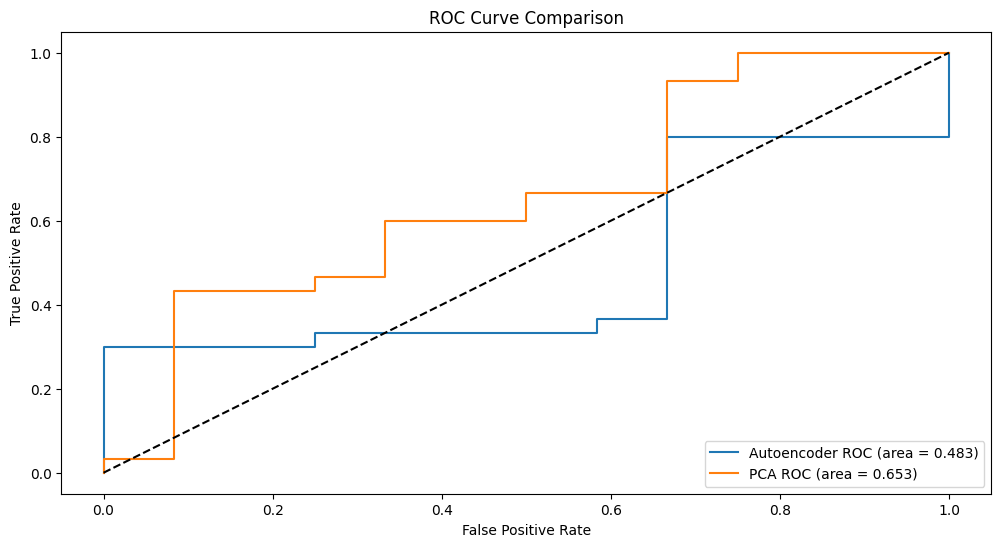

Autoencoder AUC-ROC: 0.48333333333333334
PCA AUC-ROC: 0.6527777777777778


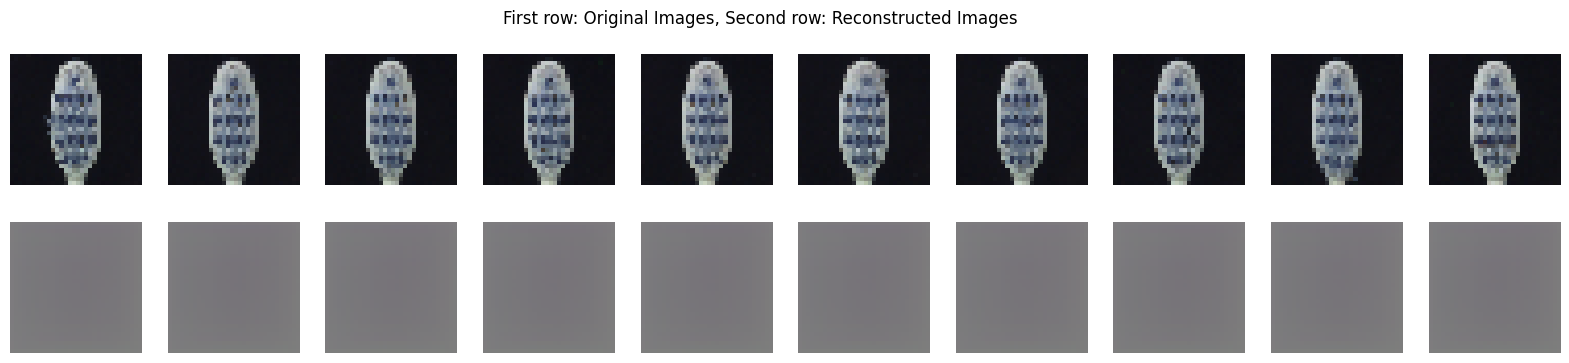

In [ ]:
# Autoencoder structure for MVTec-AD dataset

!pip install tensorflow-datasets
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

train_dir = '/datasets/traindata'
test_anomaly_dir = '/datasets/testanomaly'
test_normal_dir = '/datasets/testnormal'
#Autoencoder AUC-ROC: 0.5305555555555556, PCA AUC-ROC: 0.5777777777777777, Bayesian
#Autoencoder AUC-ROC: 0.6222222222222223, PCA AUC-ROC: 0.5805555555555556, Hyperband


img_width, img_height = 32, 32
batch_size = 16

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)
            img = img / 255.0  
            images.append(img)
    return np.array(images)

x_train_normal = load_images(train_dir)
x_test_anomalous = load_images(test_anomaly_dir)
x_test_normal = load_images(test_normal_dir)

def build_deep_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

optimizer2 = Adam(learning_rate=0.008354244185064603)

autoencoder2 = build_deep_autoencoder()
autoencoder2.compile(optimizer=optimizer2, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

augmentation_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i in range(x_train_normal.shape[0]):
    img = x_train_normal[i]
    img = img.reshape((1,) + img.shape)
    for x_batch in augmentation_generator.flow(img, batch_size=1):
        augmented_images.append(x_batch[0])
        break 

augmented_images = np.array(augmented_images)

extended_train_images = np.concatenate((x_train_normal, augmented_images))

history2 = autoencoder2.fit(
    extended_train_images, extended_train_images,
    epochs=100, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

reconstruction_normal_2 = autoencoder2.predict(x_test_normal)
reconstruction_anomalous_2 = autoencoder2.predict(x_test_anomalous)

reconstruction_normal = reconstruction_normal_2
reconstruction_anomalous = reconstruction_anomalous_2

mae_normal = np.mean(np.abs(reconstruction_normal - x_test_normal), axis=(1,2,3))
mae_anomalous = np.mean(np.abs(reconstruction_anomalous - x_test_anomalous), axis=(1,2,3))
errors = np.concatenate([mae_normal, mae_anomalous])

labels = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_anomalous))])
auc_roc_autoencoder = roc_auc_score(labels, errors)

encoded_features = np.concatenate([reconstruction_normal, reconstruction_anomalous], axis=0)
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(encoded_features_flat)
auc_roc_pca = roc_auc_score(labels, np.linalg.norm(pca_features, axis=1))

fpr_autoencoder, tpr_autoencoder, _ = roc_curve(labels, errors)
fpr_pca, tpr_pca, _ = roc_curve(labels, np.linalg.norm(pca_features, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder ROC (area = {:.3f})'.format(auc_roc_autoencoder))
plt.plot(fpr_pca, tpr_pca, label='PCA ROC (area = {:.3f})'.format(auc_roc_pca))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('PCA AUC-ROC:', auc_roc_pca)

n = 10 
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    original_image = x_test_anomalous[i].reshape(32, 32, 3)
    plt.imshow(original_image)
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_image = reconstruction_anomalous[i].reshape(32, 32, 3)
    plt.imshow(reconstructed_image)
    ax.axis('off')

plt.suptitle("First row: Original Images, Second row: Reconstructed Images")
plt.show()

In [ ]:
# Finding the AUC-ROC of the best method from ADBENCH
!pip install pyod  

from pyod.models.cblof import CBLOF
from sklearn.metrics import roc_auc_score

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

x_train_normal_flat = flatten_images(x_train_normal)
x_test_normal_flat = flatten_images(x_test_normal)
x_test_anomalous_flat = flatten_images(x_test_anomalous)

cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=42)
cblof.fit(x_train_normal_flat)

cblof_scores_normal = -cblof.decision_function(x_test_normal_flat)  # Negative scores for consistency with AUC-ROC
cblof_scores_anomalous = -cblof.decision_function(x_test_anomalous_flat)

cblof_scores = np.concatenate([cblof_scores_normal, cblof_scores_anomalous])
cblof_labels = np.concatenate([np.zeros(len(cblof_scores_normal)), np.ones(len(cblof_scores_anomalous))])

auc_roc_cblof = roc_auc_score(cblof_labels, cblof_scores)

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('CBLOF AUC-ROC:', auc_roc_cblof)

Autoencoder AUC-ROC: 0.48333333333333334
CBLOF AUC-ROC: 0.11944444444444444


In [ ]:
#Best hyperparameter for MVTec-AD using the Bayesian Optimization

!pip install keras-tuner
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner import BayesianOptimization

# Directory paths
train_dir = '/datasets/traindata'
test_anomaly_dir = '/datasets/testanomaly'
test_normal_dir = '/datasets/testnormal'

img_width, img_height = 32, 32
batch_size = 16

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)
            img = img / 255.0 
            images.append(img)
    return np.array(images)

x_train_normal = load_images(train_dir)
x_test_anomalous = load_images(test_anomaly_dir)
x_test_normal = load_images(test_normal_dir)

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy')
    return autoencoder

optimal_learning_rates = {}

for build_fn, learning_rate_key in zip(
    [build_deep_autoencoder],
    ['learning_rate_deep']):

    tuner = BayesianOptimization(
        build_fn,
        objective='val_loss',
        max_trials=20,
        directory='autoencoder_tuning',
        project_name='bayesian_mvtecAD_autoencoder',
        overwrite=True
    )
    tuner.search(x_train_normal, x_train_normal, epochs=10, validation_data=(x_test_normal, x_test_normal))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_learning_rates[build_fn.__name__] = best_hps.get(learning_rate_key)

for architecture, lr in optimal_learning_rates.items():
    print(f"Best learning rate for {architecture}: {lr}")

Trial 20 Complete [00h 00m 03s]
val_loss: 0.014406961388885975

Best val_loss So Far: 0.013003475964069366
Total elapsed time: 00h 01m 17s
Best learning rate for build_deep_autoencoder: 0.00879718431968724


In [ ]:
#Best hyperparameter for MVTec-AD using the Hyperband Optimization

!pip install keras-tuner
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import Hyperband

# Directory paths
train_dir = '/content/sample_data/train_toothbrush'
test_anomaly_dir = '/content/sample_data/test_toothbrush_broken'
test_normal_dir = '/content/sample_data/test_toothbrush_normal'

img_width, img_height = 32, 32
batch_size = 16

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)
            img = img / 255.0  
            images.append(img)
    return np.array(images)

x_train_normal = load_images(train_dir)
x_test_anomalous = load_images(test_anomaly_dir)
x_test_normal = load_images(test_normal_dir)

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy')
    return autoencoder

tuner = Hyperband(
    build_deep_autoencoder,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband_tuning',
    project_name='hyperband_MVTecAD_autoencoder',
    overwrite=True
)

tuner.search(x_train_normal, x_train_normal, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate_deep')}")

Trial 30 Complete [00h 00m 14s]
val_loss: 0.024594033136963844

Best val_loss So Far: 0.01971747912466526
Total elapsed time: 00h 03m 23s
Best learning rate: 0.0005749893799653069


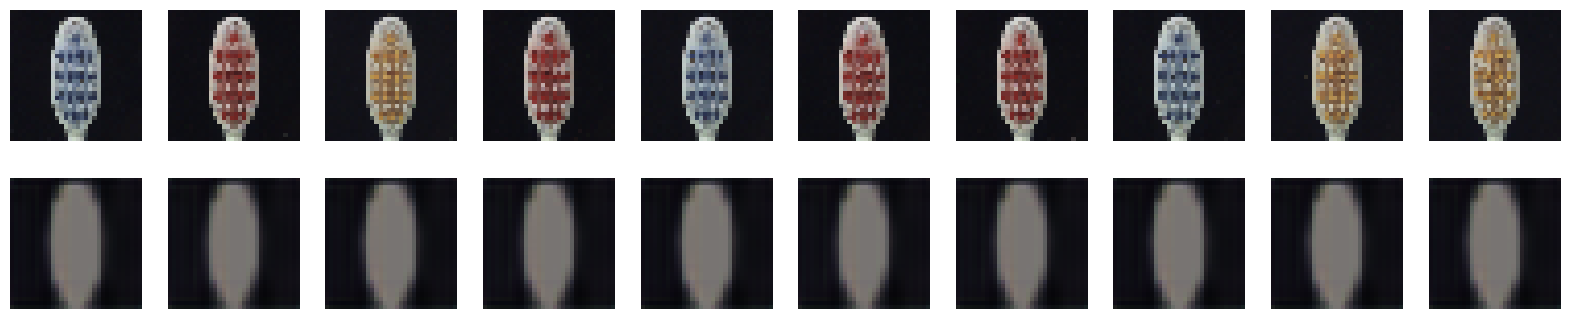

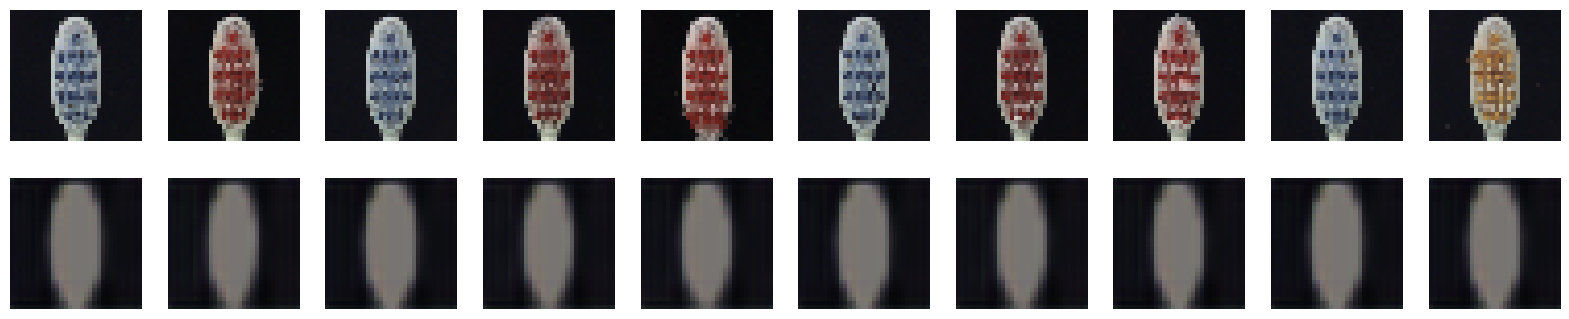

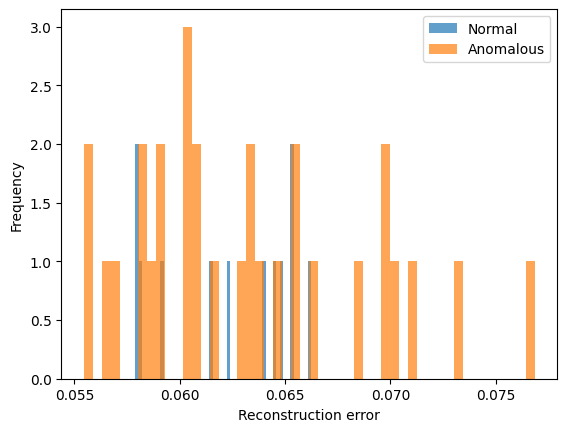

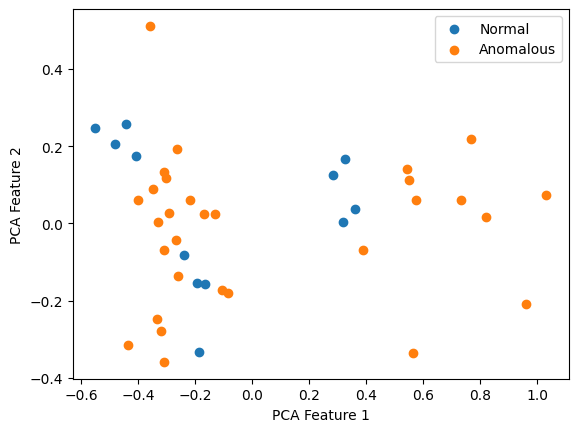

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA


def plot_comparison(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(32, 32, 3))
        ax.axis('off')

        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape(32, 32, 3))
        ax.axis('off')
    plt.show()

plot_comparison(x_test_normal, reconstruction_normal_2)
plot_comparison(x_test_anomalous, reconstruction_anomalous_2)

def plot_error_distribution(errors_normal, errors_anomalous):
    plt.hist(errors_normal, bins=50, alpha=0.7, label='Normal')
    plt.hist(errors_anomalous, bins=50, alpha=0.7, label='Anomalous')
    plt.xlabel('Reconstruction error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_error_distribution(mae_normal, mae_anomalous)

def plot_pca(encoded_features, labels):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(encoded_features)
    plt.scatter(pca_result[labels==0, 0], pca_result[labels==0, 1], label='Normal')
    plt.scatter(pca_result[labels==1, 0], pca_result[labels==1, 1], label='Anomalous')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.legend()
    plt.show()

encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
plot_pca(encoded_features_flat, labels)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 61.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


2024-01-11 22:49:32.327929: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteK3C3GQ/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteK3C3GQ/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteK3C3GQ/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.
Epoch 1/100
15/15 [==============================] - 4s 65ms/step - loss: 0.6828 - val_loss: 0.6563
Epoch 2/100
15/15 [==============================] - 0s 24ms/step - loss: 0.6495 - val_loss: 0.6202
Epoch 3/100
15/15 [==============================] - 0s 23ms/step - loss: 0.6290 - val_loss: 0.6019
Epoch 4/100
15/15 [==============================] - 0s 23ms/step - loss: 0.6210 - val_loss: 0.5982
Epoch 5/100
15/15 [==============================] - 0s 24ms/step - loss: 0.6208 - val_loss: 0.5932
Epoch 6/100
15/15 [==============================] - 0s 24ms/step - loss: 0.6164 - val_loss: 0.5894
Epoch 7/100
15/15 [==============================] - 0s 24ms/step - loss: 0.6154 - val_loss: 0.5876
Epoch 8/100
15/15 [==============================] - 0s 23ms/step - loss: 0.6140 - val_loss: 0.5861
Epoch 9/100
15/15 [==============================] - 0s 23ms/step -

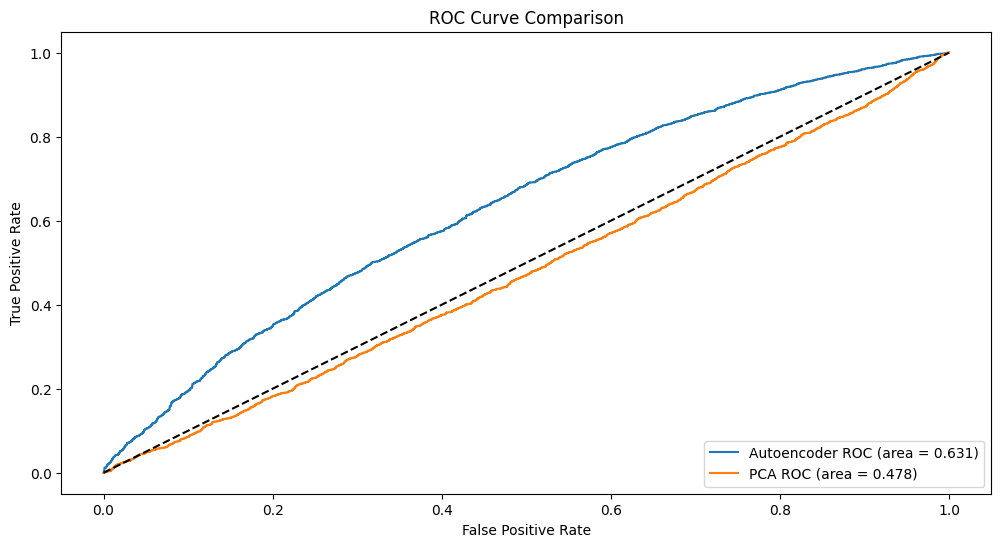

Autoencoder AUC-ROC: 0.6307884231659489
PCA AUC-ROC: 0.47826301068127514


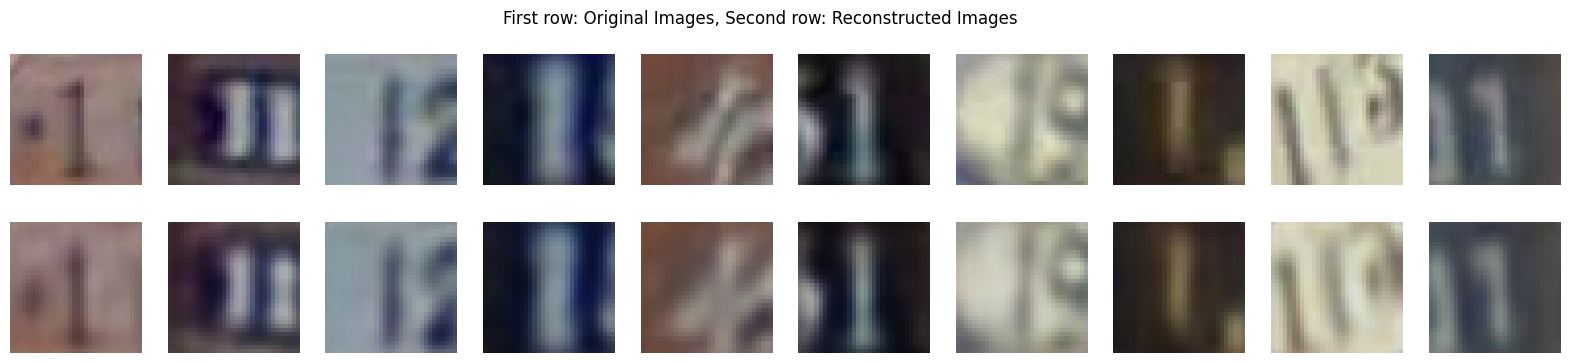

In [ ]:
# Autoencoder structure for SVHN dataset

!pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

(train_data, test_data), info = tfds.load('svhn_cropped', split=['train', 'test'], with_info=True, as_supervised=True)
#Autoencoder AUC-ROC: 0.6308323881275937, PCA AUC-ROC: 0.46626290948817906, Bayesian
#Autoencoder AUC-ROC: 0.6272092700244436, PCA AUC-ROC: 0.46946971133441273, Hyperband

def process_data_subset(dataset, normal_class, subset_size=10000):
    x, y = [], []
    for image, label in tfds.as_numpy(dataset.take(subset_size)):
        x.append(image)
        y.append(int(label == normal_class))
    return np.array(x), np.array(y)

normal_class = 1  # Define digit '1' as normal
subset_size = 10000  

x_train, y_train = process_data_subset(train_data, normal_class, subset_size)
x_test, y_test = process_data_subset(test_data, normal_class, subset_size)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

x_train_normal = x_train[y_train == 1]
x_test_normal = x_test[y_test == 1]
x_test_anomalous = x_test[y_test == 0]

def build_deep_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_img, decoded)

optimizer2 = Adam(learning_rate=0.0010027526530161435)

autoencoder2 = build_deep_autoencoder()
autoencoder2.compile(optimizer=optimizer2, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

augmentation_generator = ImageDataGenerator(
    #rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i in range(x_train_normal.shape[0]):
    img = x_train_normal[i]
    img = img.reshape((1,) + img.shape)
    for x_batch in augmentation_generator.flow(img, batch_size=1):
        augmented_images.append(x_batch[0])
        break 

augmented_images = np.array(augmented_images)

extended_train_images = np.concatenate((x_train_normal, augmented_images))

history2 = autoencoder2.fit(
    extended_train_images, extended_train_images,
    epochs=100, batch_size=256,
    validation_data=(x_test_normal, x_test_normal),
    callbacks=[early_stopping]
)

reconstruction_normal_2 = autoencoder2.predict(x_test_normal)
reconstruction_anomalous_2 = autoencoder2.predict(x_test_anomalous)

reconstruction_normal = reconstruction_normal_2
reconstruction_anomalous = reconstruction_anomalous_2

mae_normal = np.mean(np.abs(reconstruction_normal - x_test_normal), axis=(1,2,3))
mae_anomalous = np.mean(np.abs(reconstruction_anomalous - x_test_anomalous), axis=(1,2,3))
errors = np.concatenate([mae_normal, mae_anomalous])

labels = np.concatenate([np.zeros(len(mae_normal)), np.ones(len(mae_anomalous))])
auc_roc_autoencoder = roc_auc_score(labels, errors)

encoded_features = np.concatenate([reconstruction_normal, reconstruction_anomalous], axis=0)
encoded_features_flat = encoded_features.reshape(encoded_features.shape[0], -1)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(encoded_features_flat)
auc_roc_pca = roc_auc_score(labels, np.linalg.norm(pca_features, axis=1))

fpr_autoencoder, tpr_autoencoder, _ = roc_curve(labels, errors)
fpr_pca, tpr_pca, _ = roc_curve(labels, np.linalg.norm(pca_features, axis=1))

plt.figure(figsize=(12, 6))
plt.plot(fpr_autoencoder, tpr_autoencoder, label='Autoencoder ROC (area = {:.3f})'.format(auc_roc_autoencoder))
plt.plot(fpr_pca, tpr_pca, label='PCA ROC (area = {:.3f})'.format(auc_roc_pca))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('PCA AUC-ROC:', auc_roc_pca)

n = 10  # Number of samples to display
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    original_image = x_test_normal[i].reshape(32, 32, 3)
    plt.imshow(original_image)
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_image = reconstruction_normal[i].reshape(32, 32, 3)
    plt.imshow(reconstructed_image)
    ax.axis('off')

plt.suptitle("First row: Original Images, Second row: Reconstructed Images")
plt.show()

In [ ]:
# FINDING the AUC-ROC of the best method from the ADBENCH for SVHN dataset
!pip install scikit-learn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score

def flatten_images(images):
    return images.reshape(images.shape[0], -1)

x_train_normal_flat = flatten_images(x_train_normal)
x_test_normal_flat = flatten_images(x_test_normal)
x_test_anomalous_flat = flatten_images(x_test_anomalous)

lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
lof.fit(x_train_normal_flat)

lof_scores_normal = -lof.decision_function(x_test_normal_flat)
lof_scores_anomalous = -lof.decision_function(x_test_anomalous_flat)

lof_scores = np.concatenate([lof_scores_normal, lof_scores_anomalous])
lof_labels = np.concatenate([np.zeros(len(lof_scores_normal)), np.ones(len(lof_scores_anomalous))])

auc_roc_lof = roc_auc_score(lof_labels, lof_scores)

print('Autoencoder AUC-ROC:', auc_roc_autoencoder)
print('LOF AUC-ROC:', auc_roc_lof)


Autoencoder AUC-ROC: 0.6307884231659489
LOF AUC-ROC: 0.596122143014336


In [ ]:
#Best hyperparameter for SVHN using the Bayesian Optimization

!pip install keras-tuner
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from kerastuner import BayesianOptimization

(train_data, test_data), info = tfds.load('svhn_cropped', split=['train', 'test'], with_info=True, as_supervised=True)

def process_data_subset(dataset, normal_class, subset_size=10000):
    x, y = [], []
    for image, label in tfds.as_numpy(dataset.take(subset_size)):
        x.append(image)
        y.append(int(label == normal_class))
    return np.array(x), np.array(y)

normal_class = 1  # Define digit '1' as normal
subset_size = 10000  

x_train, y_train = process_data_subset(train_data, normal_class, subset_size)
x_test, y_test = process_data_subset(test_data, normal_class, subset_size)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

x_train_normal = x_train[y_train == 1]
x_test_normal = x_test[y_test == 1]
x_test_anomalous = x_test[y_test == 0]

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_basic', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_varied_filter_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_varied_filter', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

optimal_learning_rates = {}

for build_fn, learning_rate_key in zip(
    [build_basic_autoencoder, build_deep_autoencoder, build_varied_filter_autoencoder],
    ['learning_rate_basic', 'learning_rate_deep', 'learning_rate_varied_filter']):

    tuner = BayesianOptimization(
        build_fn,
        objective='val_loss',
        max_trials=10,
        directory='autoencoder_tuning',
        project_name='cifar10_autoencoder',
        overwrite=True
    )
    tuner.search(x_train_normal, x_train_normal, epochs=10, validation_data=(x_test_normal, x_test_normal))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_learning_rates[build_fn.__name__] = best_hps.get(learning_rate_key)

for architecture, lr in optimal_learning_rates.items():
    print(f"Best learning rate for {architecture}: {lr}")


Trial 10 Complete [00h 00m 05s]
val_loss: 3.986414867540589e-06

Best val_loss So Far: 3.98567181036924e-06
Total elapsed time: 00h 00m 56s
Best learning rate for build_basic_autoencoder: 0.0012363930267826038
Best learning rate for build_deep_autoencoder: 0.0003930606844525207
Best learning rate for build_varied_filter_autoencoder: 0.0015196163551258527


In [ ]:
#Best hyperparameter for SVHN using the Hyperband

!pip install keras-tuner
!pip install tensorflow-datasets
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from kerastuner import BayesianOptimization
from kerastuner.tuners import Hyperband

(train_data, test_data), info = tfds.load('svhn_cropped', split=['train', 'test'], with_info=True, as_supervised=True)

def process_data_subset(dataset, normal_class, subset_size=10000):
    x, y = [], []
    for image, label in tfds.as_numpy(dataset.take(subset_size)):
        x.append(image)
        y.append(int(label == normal_class))
    return np.array(x), np.array(y)

normal_class = 1  # Define digit '1' as normal
subset_size = 10000  

x_train, y_train = process_data_subset(train_data, normal_class, subset_size)
x_test, y_test = process_data_subset(test_data, normal_class, subset_size)

x_train = tf.image.resize(x_train, [32, 32]) / 255.0
x_test = tf.image.resize(x_test, [32, 32]) / 255.0

x_train = x_train.numpy() if isinstance(x_train, tf.Tensor) else x_train
x_test = x_test.numpy() if isinstance(x_test, tf.Tensor) else x_test

x_train_normal = x_train[y_train == 1]
x_test_normal = x_test[y_test == 1]
x_test_anomalous = x_test[y_test == 0]

x_train_normal, x_test_normal, x_test_anomalous = x_train_normal / 255.0, x_test_normal / 255.0, x_test_anomalous / 255.0

def build_basic_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_basic', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_deep_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_deep', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

def build_varied_filter_autoencoder(hp):
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    learning_rate = hp.Float('learning_rate_varied_filter', 1e-5, 1e-2, sampling='LOG')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
    return autoencoder

optimal_learning_rates = {}

for build_fn, learning_rate_key in zip(
    [build_basic_autoencoder, build_deep_autoencoder, build_varied_filter_autoencoder],
    ['learning_rate_basic', 'learning_rate_deep', 'learning_rate_varied_filter']):

    tuner = Hyperband(
        build_fn,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='hyperband_tuning',
        project_name='cifar10_autoencoder',
        overwrite=True
    )
    tuner.search(x_train_normal, x_train_normal, epochs=10, validation_split=0.2)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_learning_rates[build_fn.__name__] = best_hps.get(learning_rate_key)

for architecture, lr in optimal_learning_rates.items():
    print(f"Best learning rate for {architecture}: {lr}")

Trial 30 Complete [00h 00m 04s]
val_loss: 0.0002533897932153195

Best val_loss So Far: 3.6494900541583775e-06
Total elapsed time: 00h 01m 06s
Best learning rate for build_basic_autoencoder: 0.0019141029173084542
Best learning rate for build_deep_autoencoder: 0.0007135330733275847
Best learning rate for build_varied_filter_autoencoder: 0.001782419041940522
